Notes: 
 - consistent colors for all methods
 - bold or somehow distinguish the `random` and `oracle` methods

In [1]:
library(tidyverse)
library(RColorBrewer)
library(stringr)
library(magrittr)

Warning message:
: replacing previous import by ‘tidyr::%>%’ when loading ‘broom’Warning message:
: replacing previous import by ‘tidyr::gather’ when loading ‘broom’Warning message:
: replacing previous import by ‘tidyr::spread’ when loading ‘broom’── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
Warning message:
: package ‘ggplot2’ was built under R version 3.2.5Warning message:
: package ‘tidyr’ was built under R version 3.2.5Warning message:
: package ‘readr’ was built under R version 3.2.5Warning message:
: package ‘purrr’ was built under R version 3.2.5Warning message:
: package ‘dplyr’ was built under R version 3.2.5Warning message:
: package ‘stringr’ was built under R version 3.2.5Warning message:
: package ‘forcats’ was built under R version 3.2.5── Conflicts ────────────────────────────────────────── ti

In [2]:
results = read_csv("data/experimental_results_full.csv")

Parsed with column specification:
cols(
  model = col_character(),
  selection_method = col_character(),
  true_hte_error = col_double(),
  true_value = col_double(),
  DGP = col_character(),
  n_train = col_double(),
  n_test = col_double(),
  n_folds = col_integer(),
  rep = col_integer()
)


In [3]:
method_renames = c(
    'random' = "Random",
    'match_mse'= "Covariate matched-pairs / MSE",
    'trans_mse'= "Transformed outcome / MSE",
    'trans_mse_est_prop'= "Transformed outcome / MSE with estimated propensity",
    'match_decision' = "Covariate matched-pairs / decision cost",
    'trans_decision'= "Transformed outcome / decision cost (neg. generalized gain)",
    'trans_decision_est_prop'= "Transformed outcome / decision cost (neg. generalized gain) with estimated propensity",
    'gain' = "Traditional gain",
    'value'= "Decision value",
    'value_est_prop'= "Decision value with estimated propensity",
    'c_benefit' = "C-for-benefit",
    'qini'= "Qini coefficient (gain-at-k AUC)", 
    'value_auc'= 'Value-at-k AUC',
    'est_te_strata' = "Est. treatment effect strata / MSE",
    'prediction_error'= "Outcome prediction MSE",
    'oracle_selector_true_value' = "v",
    "oracle_selector_true_hte_error" = "tmse",
    "oracle" = "oracle"
) %>% map_chr(~str_wrap(.,22))

In [5]:
rel_diff = function(error, method, opt_method_name) {
    return(error - error[method==opt_method_name])
}

rel = function(error, method, opt_method_name) {
    return((error - error[method==opt_method_name])/(error[method=="oracle_selector_true_hte_error"] - error[method=="oracle"]))
}

In [6]:
no_prop_methods = c("random", "match_mse", "match_decision", "gain", "c_benefit", "qini", "value_auc", "est_te_strata", "prediction_error")

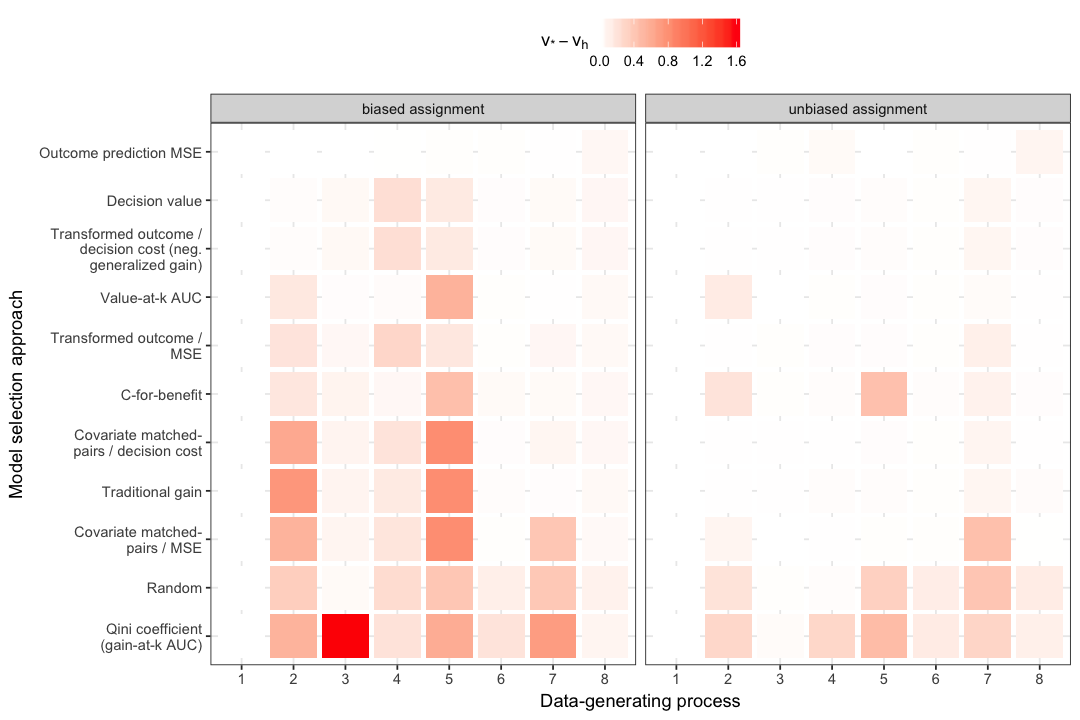

In [7]:
options(repr.plot.width=9, repr.plot.height=6)

rank_plot_data = results %>%
    filter(selection_method != "est_te_strata") %>%
    mutate(assignment = ifelse(str_detect(DGP, "biased"), "biased assignment", "unbiased assignment")) %>%
    mutate(DGP = str_replace(DGP, "biased_", "")) %>%
    mutate(DGP = str_replace(DGP, "scenario_", "")) %>%
    group_by(DGP, assignment, n_folds, rep) %>% # within each simulation, get relative performance per method
    mutate(rel_true_hte_error = rel_diff(true_hte_error, selection_method, "oracle_selector_true_hte_error"),
           rel_true_value = rel_diff(true_value, selection_method, "oracle_selector_true_value")) %>%
    filter((str_detect(selection_method,"_est_prop") & (assignment=="biased assignment")) | # join _est_prop methods
           (!str_detect(selection_method,"_est_prop") & (assignment=="unbiased assignment")) |
           selection_method %in% no_prop_methods) %>%
    mutate(selection_method = str_replace(selection_method, "_est_prop", "")) %>%
    group_by(DGP, assignment, n_folds, selection_method) %>% # now average over reps within each method
    summarize(mean_value = mean(rel_true_value, na.rm=T), mean_tmse = mean(rel_true_hte_error, na.rm=T)) %>%
    ungroup() %>%
    filter(!str_detect(selection_method, "oracle")) %>%
    group_by(DGP, assignment, n_folds) %>%
    mutate(rank_value = rank(mean_value), rank_tmse = rank(mean_tmse)) %>%
    mutate(best_value = ifelse(rank_value==1, 1, NA), best_tmse=ifelse(rank_tmse==1, 1, NA)) %>%
    ungroup()

method_order = rank_plot_data %>%
    group_by(selection_method) %>%
    summarize(mean_rank = mean(mean_value)) %>%
    arrange(-mean_rank) %>%
    pull(selection_method)

rank_plot_data %>%
    filter(n_folds == 5) %>%
    mutate(selection_method = factor(selection_method, levels=method_order)) %>%
ggplot(aes(x=DGP, y=selection_method, fill=mean_value)) +
    geom_tile(size=1, height=0.9, width=0.9) +
#     scale_color_manual(guide=F, values=c(NA,"black")) + 
    scale_fill_gradient(name=expression(v[plain("*")] - v[h]), low="white", high="red") + 
    facet_grid(~assignment) +
    theme_bw() +
    scale_y_discrete(labels=method_renames) +
    xlab("Data-generating process") +
    ylab("Model selection approach") + 
    theme(legend.position="top")
ggsave("paper/figures/value-sim-comparison.png", units="in", width=9, height=6)

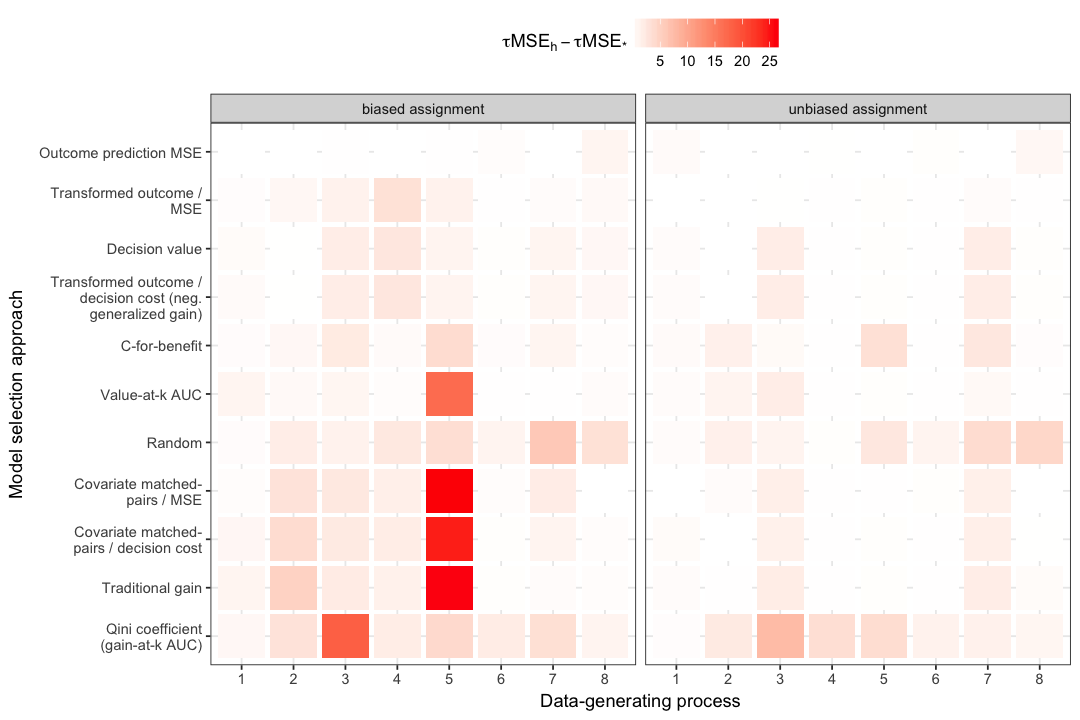

In [8]:
method_order = rank_plot_data %>%
    group_by(selection_method) %>%
    summarize(mean_rank = mean(mean_tmse)) %>%
    arrange(-mean_rank) %>%
    pull(selection_method)

rank_plot_data %>%
    filter(n_folds == 5) %>%
    mutate(selection_method = factor(selection_method, levels=method_order)) %>%
ggplot(aes(x=DGP, y=selection_method, fill=mean_tmse)) +
    geom_tile(size=1, height=0.9, width=0.9) +
#     geom_tile(aes(color=!is.na(best_tmse)), size=1, height=0.9, width=0.9) +
#     scale_color_manual(guide=F, values=c(NA,"black")) + 
    scale_fill_gradient(name=expression(tau * plain(MSE)[h] - tau * plain(MSE)[plain("*")]), low="white", high="red") + 
    facet_grid(~assignment) +
    theme_bw() +
    scale_y_discrete(labels=method_renames) +
    xlab("Data-generating process") +
    ylab("Model selection approach") + 
    theme(legend.position="top")
ggsave("paper/figures/tmse-sim-comparison.png", units="in", width=9, height=6)

# Junk... ?

In [205]:
rel_tmse = function(error, method) {
    return(error - error[method=="oracle_selector_true_hte_error"])
}

# rel_cost = function(error, method) {
#     return((error - error[method=="oracle"])/(error[method=="oracle_selector_true_value"] - error[method=="oracle"]))
# }

rel_cost = function(error, method) {
    return((error[method=="oracle_selector_true_value"] - error))
}

In [52]:
all_methods = results %>% pull(selection_method) %>% unique
method_types = list(
    framework_methods = c("trans_decision", "trans_mse", "match_decision", "match_mse", "trans_decision_est_prop", "trans_mse_est_prop", "random"),
    value_methods = c("gain", "trans_decision", "trans_decision_est_prop", "value", "value_est_prop", "match_decision", "random"),
    mse_methods = c("prediction_error", "trans_mse", "match_mse", "trans_mse_est_prop", "random"),
    ranking_methods = c("value_auc", "c_benefit", "qini", "random"),
    misc_methods = c("est_te_strata", "random"),
#     comparator_methods = c("oracle", "oracle_selector_true_hte_error", "oracle_selector_true_value", "random", "prediction_error"),
    winner_methods = c("trans_mse", "value", "prediction_error", "random")
)

In [53]:
rb_col = brewer.pal(length(method_types$framework_methods)-1,"Spectral")
bl_col = brewer.pal(length(method_types$value_methods)-1,"Blues")
pr_col = brewer.pal(length(method_types$ranking_methods)-1,"Purples")
br_col = c("saddlebrown", "sandybrown", "sienna2")

darken = function(color, factor=1.4){
    col = col2rgb(color)
    col = col/factor
    col = rgb(t(col), maxColorValue=255)
    col
}

In [55]:
method_fills = c(
    'random' = "grey",
    'match_mse'=rb_col[1],
    'trans_mse'=rb_col[2],
    'trans_mse_est_prop' = rb_col[5],
    'match_decision'=rb_col[3],
    'trans_decision'=rb_col[4],
    'trans_decision_est_prop' = rb_col[6],
    'gain'= bl_col[1],
    'value'= bl_col[2],
    'value_est_prop' = bl_col[3],
    'c_benefit' = pr_col[1],
    'qini'= pr_col[2], 
    'value_auc'= pr_col[3],
    'est_te_strata' = "pink",
    'prediction_error'= "wheat"
) 
# names(method_fills) = method_renames
method_colors = method_fills %>%
    map_chr(darken) %>%
    c
# names(method_colors) = method_renames

In [66]:
rel_results = results %>%
    mutate(assignment = ifelse(str_detect(DGP, "biased"), "biased assignment", "unbiased assignment")) %>%
    mutate(DGP = str_replace(DGP, "biased_", "")) %>%
    mutate(DGP = str_replace(DGP, "scenario_", "")) %>%
    group_by(DGP, n_folds, rep, n_train, n_test, assignment) %>%
    mutate(rel_true_hte_error = rel_tmse(true_hte_error, selection_method)) %>%
    mutate(rel_true_value = rel_cost(true_value, selection_method)) %>%
    filter((str_detect(selection_method,"_est_prop") & (assignment=="biased assignment")) |
           (!str_detect(selection_method,"_est_prop") & (assignment=="unbiased assignment")) |
           selection_method %in% no_prop_methods) %>%
    mutate(selection_method = str_replace(selection_method, "_est_prop", "")) %>%
    mutate(selection_method = factor(selection_method, levels=names(method_renames)))

In [68]:
full_error_plot = function(rel_results, fills, colors, methods) {
    rel_results %>%
        filter(selection_method %in% methods) %>%
#     ggplot(aes(x=as.factor(DGP), y=log10(rel_true_hte_error), 
    ggplot(aes(x=as.factor(DGP), y=true_hte_error, 
               fill=selection_method, color=selection_method)) +
        geom_boxplot() +
        scale_fill_manual(name="Selection method", values = fills, labels = method_renames) + 
        scale_color_manual(name="Selection method", values = colors, labels = method_renames) + 
        facet_grid(n_folds~assignment) +
        xlab("Data-generating process") + 
        ylab(expression(log(R* plain("-") *tau * plain(MSE)[h]))) +
        theme_bw() +
        theme(legend.key.height=unit(2, "cm")) + 
        theme(legend.key.width=unit(0.5, "cm"))
}

full_value_plot = function(rel_results, fills, colors, methods) {
    rel_results %>%
        filter(selection_method %in% methods) %>%
#     ggplot(aes(x=as.factor(DGP), y=log10(rel_true_value), 
    ggplot(aes(x=as.factor(DGP), y=true_value, 
               fill=selection_method, color=selection_method)) +
        geom_boxplot() +
        scale_fill_manual(name="Selection method", values = fills, labels = method_renames) + 
        scale_color_manual(name="Selection method", values = colors, labels = method_renames) + 
        facet_grid(n_folds~assignment) +
        xlab("Data-generating process") + 
        ylab(expression(log(R* plain("-") * plain(C)[h]))) +
        theme_bw() +
        theme(legend.key.height=unit(2, "cm")) + 
        theme(legend.key.width=unit(0.5, "cm"))
}

plot_util = function(rel_results, fills, colors, method_type_name, methods, w, h) {
    tMSE = full_error_plot(rel_results, fills, colors, methods)
    cost = full_value_plot(rel_results, fills, colors, methods)
    ggsave(str_c("paper/figures/", method_type_name, "-tMSE.png", sep=""), tMSE, units="in", width=w, height=h)
    ggsave(str_c("paper/figures/", method_type_name, "-cost.png", sep=""), cost, units="in", width=w, height=h)
    return(NULL)
}

In [69]:
method_types %>% iwalk(~plot_util(rel_results, method_fills, method_colors, .y, .x, 9, 6))

# Framework Methods

Warning message:
: Removed 430 rows containing non-finite values (stat_boxplot).

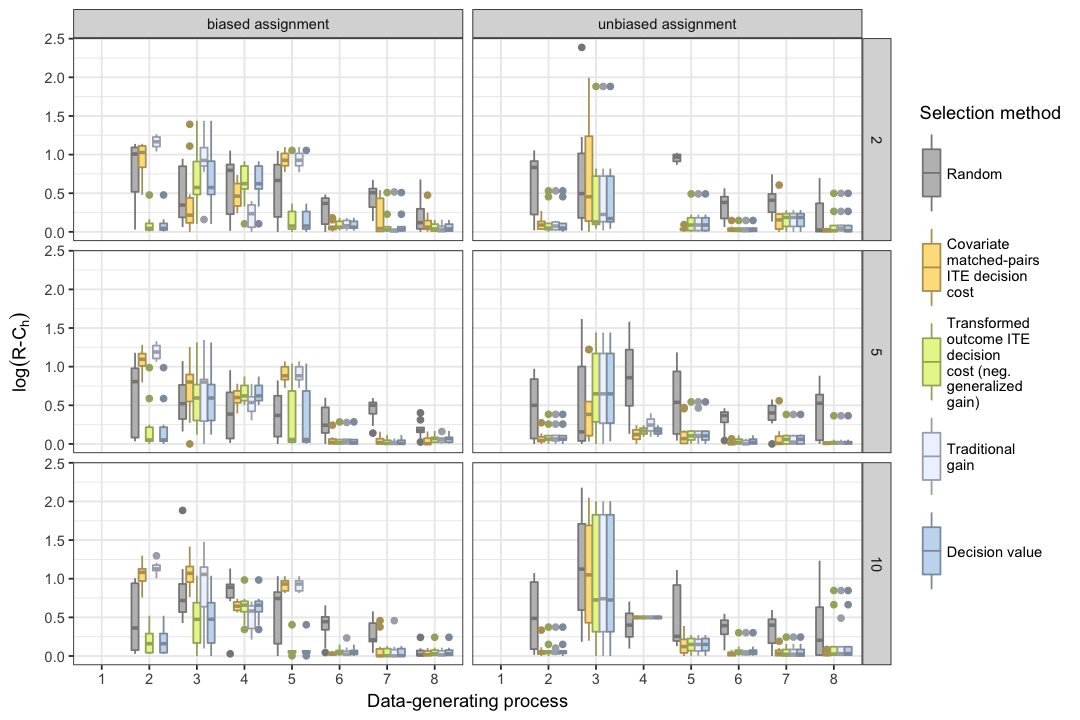

In [64]:
options(repr.plot.width=9, repr.plot.height=6)
full_value_plot(rel_results, method_fills, method_colors, c(method_types$value_methods))

In general, `Random` works decently because all of the models that are being selected from are reasonable.

`trans_mse` also seems to be doing well in terms of value. The decision-based metrics do well here, but again matching seems to hurt relative to weighting (probably because we're using the true .In terms of HTE error, `trans_mse` appears to work the best the most consistently. Matching and descision hurt a bit, trans and mse help. Number of folds doesn't matter that much. 

# Value Methods

These all do the exact same thing, as expected. Gain is a little different than the other two, but only in the biased assignment scenario because its estimating a group-wise propensity there whereas the other two have access to the true propensities.

# Ranking Methods

These all kinda suck. `value_auc` is the only one that consistently does better than random.

# Misc Methods

`random` often beats Rob's method, even with unbiased assignment

# Winner's Bracket

`trans_mse` and `prediction_error` are the winners here.

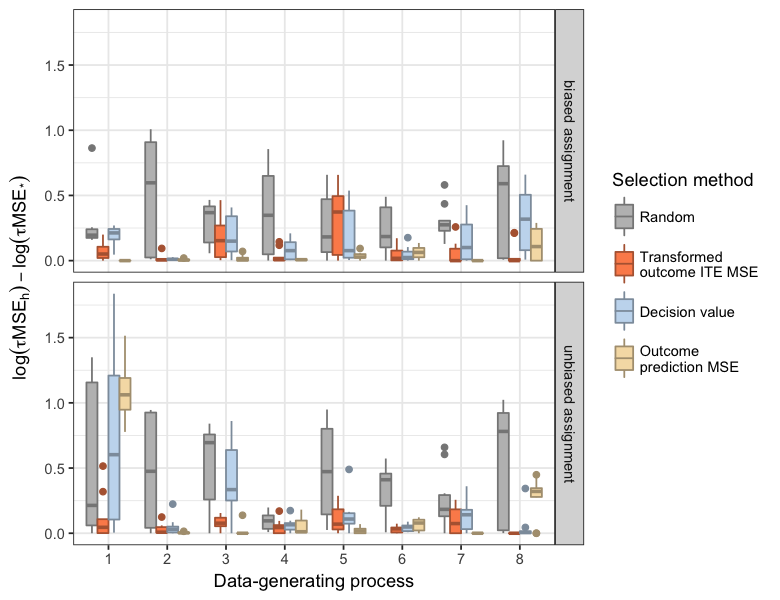

In [60]:
options(repr.plot.width=6.5, repr.plot.height=5)

rel_results %>%
    filter(selection_method %in% method_types$winner_methods) %>%
    filter(n_folds==5) %>%
ggplot(aes(x=as.factor(DGP), y=log10(rel_true_hte_error), 
           fill=selection_method, color=selection_method)) +
    geom_boxplot() +
    scale_fill_manual(name="Selection method", values = method_fills, labels = method_renames) + 
    scale_color_manual(name="Selection method", values = method_colors, labels = method_renames) + 
    facet_grid(assignment~.) +
    xlab("Data-generating process") + 
#     ylab("log(selected model error) - log(best model error)") +
    ylab(expression(log(tau * plain(MSE)[h]) - log(tau * plain(MSE)[plain("*")]))) +
    theme_bw() +
    theme(legend.key.height=unit(1, "cm")) + 

    theme(legend.key.width=unit(0.5, "cm"))

Warning message:
: Removed 556 rows containing non-finite values (stat_boxplot).

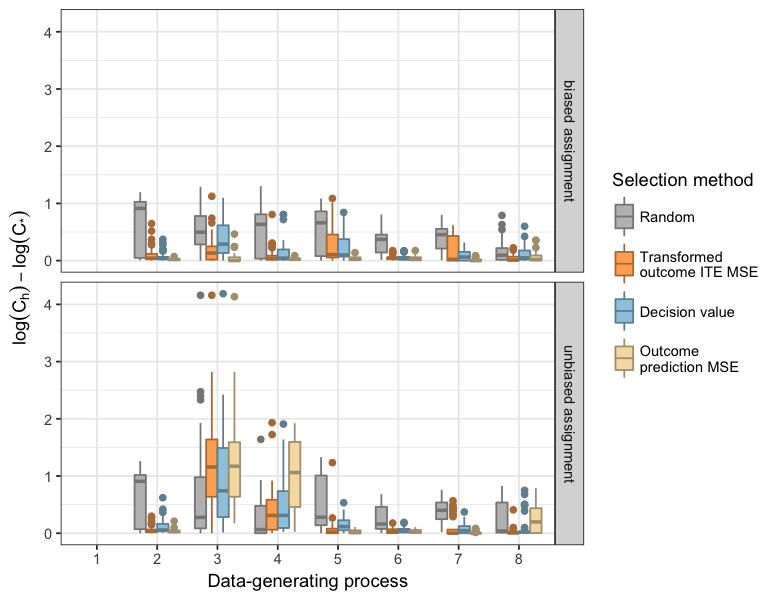

In [20]:
options(repr.plot.width=6.5, repr.plot.height=5)

rel_results %>%
    filter(selection_method %in% method_types$winner_methods) %>%
    filter(n_folds==5) %>%
    ggplot(aes(x=as.factor(DGP), y=log10(rel_true_value), 
           fill=selection_method, color=selection_method)) +
    geom_boxplot() +
    scale_fill_manual(name="Selection method", values = method_fills, labels = method_renames) + 
    scale_color_manual(name="Selection method", values = method_colors, labels = method_renames) + 
    facet_grid(assignment~.) +
    xlab("Data-generating process") + 
    ylab(expression(log(C[h]) - log(C[plain("*")]))) +
    theme_bw() +
    theme(legend.key.height=unit(1, "cm")) + 
    theme(legend.key.width=unit(0.5, "cm"))

This isn't quite right... need to look at all contrasts within the same rep, model, etc. Paired nonparametric test of means == wilcoxon signed rank test

In [26]:
rel_results %>%
    filter(selection_method %in% method_types$winner_methods) %>%
data.frame %>% head

,model,selection_method,true_hte_error,true_value,DGP,n_train,n_test,n_folds,rep,assignment,rel_true_hte_error,rel_true_value
1,gbm~61~3~0.2~3,prediction_error,0.6343864,0.06108336,1,1000,2000,2,1,unbiased assignment,12.52088,NaN
2,enet~0.5~0.0273237224472926,random,0.05092394,0.06108336,1,1000,2000,2,1,unbiased assignment,1.005086,NaN
3,gbm~1~3~0.2~3,trans_mse,0.0710684,0.06108336,1,1000,2000,2,1,unbiased assignment,1.402677,NaN
4,gbm~461~3~0.2~3,value,1.235575,0.06108336,1,1000,2000,2,1,unbiased assignment,24.38653,NaN
5,gbm~421~3~0.2~3,prediction_error,0.4140199,-0.8541191,2,1000,2000,2,1,unbiased assignment,1.02292,1.056738
6,enet~0.5~0.67032004603564,random,2.709461,-0.5994775,2,1000,2000,2,1,unbiased assignment,6.69427,4.851064


In [71]:
test_results = rel_results %>%
    filter(selection_method %in% method_types$winner_methods) %>%
    select(DGP, n_train, n_test, n_folds, rep, assignment, selection_method, true_value) %>%
    spread(selection_method, true_value) 

In [72]:
tail(test_results %>% data.frame)

,DGP,n_train,n_test,n_folds,rep,assignment,random,trans_mse,value,prediction_error
475,8,1000,2000,10,8,biased assignment,-0.6276813,-0.6298665,-0.6299027,-0.6298665
476,8,1000,2000,10,8,unbiased assignment,-0.3849071,-0.7944426,-0.8007619,-0.5876846
477,8,1000,2000,10,9,biased assignment,-0.4439474,-0.6470274,-0.6435136,-0.5205092
478,8,1000,2000,10,9,unbiased assignment,-0.6335139,-0.9147108,-0.8860616,-0.8860616
479,8,1000,2000,10,10,biased assignment,-0.7965601,-0.7966523,-0.7951882,-0.7966523
480,8,1000,2000,10,10,unbiased assignment,-0.7359168,-0.7359168,-0.6691224,-0.6691224


In [59]:
?t.test

t.test {stats},R Documentation
x,a (non-empty) numeric vector of data values.
y,an optional (non-empty) numeric vector of data values.
alternative,"a character string specifying the alternative hypothesis, must be one of ""two.sided"" (default), ""greater"" or ""less"". You can specify just the initial letter."
mu,a number indicating the true value of the mean (or difference in means if you are performing a two sample test).
paired,a logical indicating whether you want a paired t-test.
var.equal,a logical variable indicating whether to treat the two variances as being equal. If TRUE then the pooled variance is used to estimate the variance otherwise the Welch (or Satterthwaite) approximation to the degrees of freedom is used.
conf.level,confidence level of the interval.
formula,a formula of the form lhs ~ rhs where lhs is a numeric variable giving the data values and rhs a factor with two levels giving the corresponding groups.
data,an optional matrix or data frame (or similar: see model.frame) containing the variables in the formula formula. By default the variables are taken from environment(formula).
subset,an optional vector specifying a subset of observations to be used.


In [61]:
test_results %$%
#     filter(!is.na(trans_mse) & !is.na(prediction_error)) %$%
    t.test(prediction_error, trans_mse, paired=TRUE)
test_results %>% 
    mutate(diff = trans_mse-prediction_error) %>%
    pull(diff) %>%
    mean(na.rm=T)

ERROR: Error in if (stderr < 10 * .Machine$double.eps * abs(mx)) stop("data are essentially constant"): missing value where TRUE/FALSE needed


[1] 0.2242633